In [1]:
import glob
import gzip
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import stats
import sys

from Bio.Seq import Seq
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as offline
from plotly.subplots import make_subplots
import seaborn as sns

import matrix_transform
import visualize

%matplotlib inline
sns.set(font="Arial")
sns.set_theme(style="ticks")

In [33]:
fig_folder = 'Figures/'
sample_dir = 'sample_spreadsheet_021521.csv'
samples = pd.read_csv(sample_dir)

amino_acid_list = ['*', 'A', 'C', 'D', 'E', 'F', 'G', 'H',
                   'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
                   'S', 'T', 'V', 'W', 'Y']
amino_acid_list.reverse()
grouped_aa = ['H', 'K','R','D','E','C','M','N','Q','S','T','A',\
             'I','L','V','F','W','Y','G','P','*']

wt_ = ('SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDM'
       'LNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTP'
       'KYKFVRIQPGQTFSVLFLNGSCGSVG'
       'FNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTT'
       'ITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDI'
       'LGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ*')
wt_full = ('MSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICT'
           'SEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKV'
           'DTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIK'
           'GSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYG'
           'PFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLND'
           'FNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNG'
           'MNGRTILGSALLEDEFTPFDVVRQCSGVTFQ*')
wt_ = [x for x in wt_]
wt_full = [x for x in wt_full]

sets = [1, 2, 3, 4, 5, 6, 7,8, 9, 10, 11, 12, 13,\
        14, 15, 16, 17, 18, 19, 20, 'R1']
set21 = [21]
res_redo = ['8R', '9R1', '9R2', '10R1', '10R2', '13R1', '13R2', '14R', '16R']

all_sets = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 
        17, 18, 19, 20, 21, 8, 9, 10, 'R1',
       '8R', '9R1', '9R2', '10R1', '10R2', 
        '13R1', '13R2', '14R', '16R']

## Proportion of wildtype in each set

Calculate the percentage of the reads that remain wildtype. 

In [34]:
total_reads = pd.read_csv('CSVs/num_reads.csv', usecols = [1,2,3])
count_matrix_dir = 'Data/count_matrix/'

num_wt = []
for ind, row in samples.iterrows():
    file = count_matrix_dir+'res'+str(row['Start range'])\
    +'rep'+str(row['Replicate']-1)+'.csv'
    count_stats = pd.read_csv(file)
    wt = count_stats.loc[len(count_stats)-1]['count']
    num_wt.append(
        [row['Set'], row['Replicate']-1, wt])
    
wt_df = pd.DataFrame(num_wt, columns = ['set', 'replicate', 'wt'])
tot_df = pd.merge(total_reads, wt_df, on = ['set', 'replicate'])
tot_df['fraction_wt'] = tot_df['wt']/((tot_df['reads']+1)/4)

In [35]:
fig = go.Figure(data=[
    go.Bar(name='Replicate 1', x=tot_df[tot_df['replicate']==0]['set'],\
           y=tot_df[tot_df['replicate']==0]['fraction_wt'], marker_color = '#1E88E5'),
    go.Bar(name='Replicate 2', x=total_reads[total_reads['replicate']==1]['set'],\
           y=tot_df[tot_df['replicate']==1]['fraction_wt'], marker_color = '#FFC107')
])
# Change the bar mode
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(barmode='group', xaxis=dict(type='category'),
                title_text='Fraction of wildtype sequence detected per set',
                xaxis_title="Set",
                yaxis_title="Fraction wildtype",
                paper_bgcolor='rgba(255,255,255,100)',
                plot_bgcolor='rgba(255,255,255,100)',
                font=dict(family="Arial",
                                size=16,
                                color="#020202"
                                ))

fig.show()
fig.write_image(fig_folder + "FigS1_wildtype_fraction.pdf")

## Breakdown of synonymous/non-synonymous codings

In [26]:
def syn(variant, wt):
    if variant == wt:
        return('syn')
    elif variant[1] == '*':
        return('stop')
    else:
        return('non-syn')

In [27]:
mutation_master = []

for res in range(1, 307):
    for rep in [0, 1]:
        mut_type = [0,0,0]
        file = count_matrix_dir + 'res'+str(res)+'rep' + str(rep)+'.csv'
        count_stats = pd.read_csv(file, index_col = 0)
        # drop wildtype
        count_stats = count_stats.drop(len(count_stats)-1)
        translation = ''.join(wt_full[res-1:res+2])
        pre = wt_full[res-1]
        mid = wt_full[res]
        post = wt_full[res+1]
        full = pre+mid+post
        count_stats = count_stats[~count_stats.site_1.str.contains('\n')]
        count_stats = count_stats[~count_stats.site_2.str.contains('\n')]
        count_stats = count_stats[~count_stats.site_3.str.contains('\n')]
        
        count_stats['aa_1'] = count_stats['site_1'].apply(lambda x: str(Seq(x).translate()))
        count_stats['aa_2'] = count_stats['site_2'].apply(lambda x: str(Seq(x).translate()))
        count_stats['aa_3'] = count_stats['site_3'].apply(lambda x: str(Seq(x).translate()))
        filt_stats = count_stats[(count_stats['aa_1'] == pre) & (count_stats['aa_3'] == post)].copy()
        filt_stats['full'] = filt_stats['aa_1']+filt_stats['aa_2']+filt_stats['aa_3']
        
        mutation_type = filt_stats['full'].apply(lambda x: syn(x, full))
        filt_stats['mutation_type'] = mutation_type
        for ind, mut in enumerate(['syn', 'stop', 'non-syn']):
            mut_type[ind] = mut_type[ind] + filt_stats[filt_stats['mutation_type'] == mut].sum()['count']
        mutation_master.append([res, rep]+ mut_type)

In [28]:
mut_type = pd.DataFrame(mutation_master,\
             columns = ['residue', 'replicate', 'synonymous', 'stop', 'non-syn'])

mut_type['syn_frac'] = mut_type['synonymous']/\
    (mut_type['synonymous']+mut_type['stop']+mut_type['non-syn'])
mut_type['stop_frac'] = mut_type['stop']/\
    (mut_type['synonymous']+mut_type['stop']+mut_type['non-syn'])
mut_type['non-syn_frac'] = mut_type['non-syn']/\
    (mut_type['synonymous']+mut_type['stop']+mut_type['non-syn'])

In [29]:
# makde figure
fig = go.Figure(data=[
    go.Bar(name='Non-synonymous', x=list(set(mut_type['residue'])), \
           y=mut_type.groupby('residue').mean()['non-syn_frac'], marker_color = '#1E88E5'),
    go.Bar(name='Synonymous', x=list(set(mut_type['residue'])), \
           y=mut_type.groupby('residue').mean()['syn_frac'], marker_color = '#D81B60'),
    go.Bar(name='Stop', x=list(set(mut_type['residue'])), y=mut_type.groupby('residue').mean()['stop_frac'],\
          marker_color = '#FFC107')
])
# Change the bar mode
fig.update_layout(barmode='stack',
                title_text='Fraction of mutation type',
                xaxis_title="Residue",
                yaxis_title="Fraction",
                paper_bgcolor='rgba(255,255,255,100)',
                plot_bgcolor='rgba(255,255,255,100)',
                font=dict(family="Arial",
                                size=16
                                ))
fig.show()

In [30]:
fig.write_image(fig_folder+"FigS1_mutation_types.pdf", engine = 'kaleido')

## All codings

In [31]:
count_matrix_dir = 'Data/count_matrix/'
num_codings = []
for res in range(1, 307):
    for rep in [0, 1]:
        hamming_dist = [0,0,0]
        file = count_matrix_dir + 'res'+str(res)+'rep' + str(rep)+'.csv'
        count_stats = pd.read_csv(file, index_col = 0)
        pre = wt_full[res-1]
        post = wt_full[res+1]
        count_stats = count_stats[~count_stats.site_1.str.contains('\n')]
        count_stats = count_stats[~count_stats.site_2.str.contains('\n')]
        count_stats = count_stats[~count_stats.site_3.str.contains('\n')]
        count_stats['aa_1'] = count_stats['site_1'].apply(lambda x: str(Seq(x).translate()))
        count_stats['aa_2'] = count_stats['site_2'].apply(lambda x: str(Seq(x).translate()))
        count_stats['aa_3'] = count_stats['site_3'].apply(lambda x: str(Seq(x).translate()))
        
        filt_stats = count_stats[(count_stats['aa_1'] == pre) & (count_stats['aa_3'] == post)].copy()
        filt_stats['full'] = filt_stats['aa_1']+filt_stats['aa_2']+filt_stats['aa_3']
        coding = list(filt_stats.groupby(['full']).count()['site_1'])
        num_codings.append(coding)
        
codings_flatten = [item for sublist in num_codings for item in sublist]

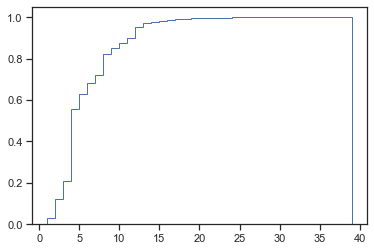

In [32]:
n_bins = 38
n, bins, patches = plt.hist(codings_flatten, n_bins, density=True, histtype='step', 
                            cumulative=1)
fig = go.Figure(data=[go.Scatter(
     x=[x+0.5 for x in [0]+list(bins)],
    y=[0]+list(n),
    mode='lines',
    name= "test",
    line=dict(
        shape='hvh'
    )
)])
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False, range=[0.5, 20])
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False, range=[0, 1.05])
fig.update_layout(
    title="Codings per residue",
    xaxis_title="Number of codings",
    yaxis_title="Fraction",
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    autosize=False,
    width=600,
    height=600,
    font=dict(family="Arial",
                    size=16,
                    color="#020202"
                    )
    )
fig.show()
fig.write_image(fig_folder+"Fig1_cumulative_hist_codings.pdf", engine = 'kaleido')

### No synonymous codings

In [18]:
count_matrix_dir = 'Data/count_matrix_glu_gal_nosyn/'
num_codings = []
for res in range(1, 307):
    for rep in [0, 1]:
        hamming_dist = [0,0,0]
        file = count_matrix_dir + 'rep_'+str(rep)+'residue' + str(res)+'.csv'
        if os.path.isfile(file):
            count_stats = pd.read_csv(file, index_col = 0)
            pre = wt_full[res-1]
            post = wt_full[res+1]
            count_stats = count_stats[~count_stats.site_2.str.contains('\n')]
            count_stats['aa_2'] = count_stats['site_2'].apply(lambda x: str(Seq(x).translate()))

            filt_stats = count_stats.copy()
            filt_stats['full'] = filt_stats['aa_2']
            coding = list(filt_stats.groupby(['full']).count()['site_2'])
            num_codings.append(coding)
        
codings_flatten = [item for sublist in num_codings for item in sublist]

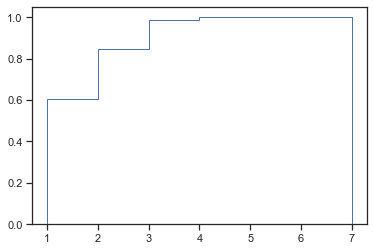

In [19]:
n_bins = 6
n, bins, patches = plt.hist(codings_flatten, n_bins, density=True, histtype='step', 
                            cumulative=1)

fig = go.Figure(data=[go.Scatter(
    x=[x+0.5 for x in [0]+list(bins)],
    y=[0]+list(n),
    mode='lines',
    name= "test",
    line=dict(
        shape='hvh'
    )
)])
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False, range=[0.5, 6])
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False, range=[0, 1.1])
fig.update_layout(
    title="Codings per residue",
    xaxis_title="Number of codings",
    yaxis_title="Fraction",
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    autosize=False,
    width=600,
    height=600,
    font=dict(family="Arial",
                    size=16,
                    color="#020202"
                    )
    )
fig.show()
fig.write_image(fig_folder+"Fig1_cumulative_hist_codings_no_synonyous_coding.pdf", 
                engine = 'kaleido')

### Number of counts detected in each condition. 

In [20]:
count_matrix_dir = 'Data/count_matrix/'
mutation_counts= []

for res in range(1, 307):
    for rep in [0, 1]:
        mut_type = [0,0,0]
        file = count_matrix_dir + 'res'+str(res)+'rep' + str(rep)+'.csv'
        count_stats = pd.read_csv(file, index_col = 0)
        # drop wildtype
        count_stats = count_stats.drop(len(count_stats)-1)
        translation = ''.join(wt_full[res-1:res+2])
        pre = wt_full[res-1]
        mid = wt_full[res]
        post = wt_full[res+1]
        full = pre+mid+post
        count_stats = count_stats[~count_stats.site_1.str.contains('\n')]
        count_stats = count_stats[~count_stats.site_2.str.contains('\n')]
        count_stats = count_stats[~count_stats.site_3.str.contains('\n')]
        
        count_stats['aa_1'] = count_stats['site_1'].apply(lambda x: str(Seq(x).translate()))
        count_stats['aa_2'] = count_stats['site_2'].apply(lambda x: str(Seq(x).translate()))
        count_stats['aa_3'] = count_stats['site_3'].apply(lambda x: str(Seq(x).translate()))
        filt_stats = count_stats[(count_stats['aa_1'] == pre) & (count_stats['aa_3'] == post)].copy()
        filt_stats['full'] = filt_stats['aa_1']+filt_stats['aa_2']+filt_stats['aa_3']
        mutation_counts.append(list(filt_stats['count']))

In [21]:
mutation_flat = [item for sublist in mutation_counts for item in sublist]

In [22]:
fig = px.histogram(mutation_flat, nbins=20000)
fig.update_xaxes(range=[0, 500],
                showline=True, linewidth=1, linecolor='black', mirror=True,
                 showgrid=False)
fig.update_yaxes(range=[0, 2000],
                showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    autosize=False,
    width=800,
    height=600,
    font=dict(family="Arial",
                    size=16,
                    color="#020202"
                    ),
    showlegend=False
    )
fig.show()
fig.write_image(fig_folder+"FigS1_counts_per_variant_zoom.pdf", engine = 'kaleido')

In [23]:
fig = px.histogram(mutation_flat, nbins=20000)
fig.update_xaxes(range = [0, 3000], title = 'Reads per variant',
                showline=True, linewidth=1, linecolor='black', mirror=True,
                 showgrid=False)
fig.update_yaxes(title = 'Number of variants',
                showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    autosize=False,
    width=800,
    height=600,
    font=dict(family="Arial",
                    size=16,
                    color="#020202"
                    ),
    showlegend=False
    )
fig.show()
fig.write_image(fig_folder+"FigS1_counts_per_variant_full.pdf", engine = 'kaleido')